## Importing all the essential libraries

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sqlalchemy
import pyodbc


In [2]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# database creation 
server = 'DESKTOP-QH0EITK'               
driver = 'ODBC Driver 17 for SQL Server'
default_database = 'master'
target_database = 'TTC_Delay_DB'

In [4]:
def create_database_sqlserver(server, driver, target_db, default_db='master'):
    conn_str = f'DRIVER={{{driver}}};SERVER={server};DATABASE={default_db};Trusted_Connection=yes;'
    conn = pyodbc.connect(conn_str, autocommit=True)
    cursor = conn.cursor()
    
    cursor.execute(f"""
        IF NOT EXISTS (SELECT name FROM sys.databases WHERE name = N'{target_db}')
        BEGIN
            CREATE DATABASE [{target_db}]
        END
    """)
    print(f"✅ Database '{target_db}' created or already exists.")

# Call the function to create the DB
create_database_sqlserver(server, driver, target_database)

✅ Database 'TTC_Delay_DB' created or already exists.


In [5]:
def get_engine(server, database, driver):
    connection_string = f"mssql+pyodbc://{server}/{database}?driver={driver.replace(' ', '+')}&trusted_connection=yes"
    return sqlalchemy.create_engine(connection_string)

In [6]:
def query_db(engine, sql_string):
    df = pd.read_sql(sql=sql_string, con=engine)
    return df

def save_table(df, table, mode, engine):
    if mode in ['replace', 'append']:
        df.to_sql(table, con=engine, if_exists=mode, index=False)
        print(f"Data saved to table '{table}' with mode '{mode}'.")


In [7]:
engine = get_engine(server, target_database, driver)

In [8]:
def load_ttc_df():
    import pandas as pd
    ttc_df = pd.read_csv("TTC.csv")
    return ttc_df


In [9]:
ttc_df = load_ttc_df()

In [10]:
ttc_df.to_sql('TTC_Delay', con=engine, if_exists='replace', index=False)
print("Data saved to table 'TTC_Delay'")


Data saved to table 'TTC_Delay'


## Overview

In [11]:
ttc_df.describe()

Route      Min Delay       Min Gap        Vehicle
count  656439.000000  657427.000000  656911.00000  586524.000000
mean      139.803837      20.059842      30.37430    5557.049693
std      1137.584571     310.882246      67.85782    3541.906856
min         1.000000     -54.000000      -2.00000       0.000000
25%        38.000000       7.000000      14.00000    1612.000000
50%        72.000000      10.000000      20.00000    7653.000000
75%       116.000000      16.000000      30.00000    8374.000000
max    898630.000000  246245.000000    6528.00000   99035.000000

In [12]:
ttc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657922 entries, 0 to 657921
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Report Date  657922 non-null  object 
 1   Route        656439 non-null  float64
 2   Time         657922 non-null  object 
 3   Day          657922 non-null  object 
 4   Location     657113 non-null  object 
 5   Incident     656987 non-null  object 
 6   Min Delay    657427 non-null  float64
 7   Min Gap      656911 non-null  float64
 8   Direction    613331 non-null  object 
 9   Vehicle      586524 non-null  float64
dtypes: float64(4), object(6)
memory usage: 50.2+ MB


In [13]:
ttc_df.columns.to_list()

['Report Date',
 'Route',
 'Time',
 'Day',
 'Location',
 'Incident',
 'Min Delay',
 'Min Gap',
 'Direction',
 'Vehicle']

In [14]:
ttc_df.isna().sum()

Report Date        0
Route           1483
Time               0
Day                0
Location         809
Incident         935
Min Delay        495
Min Gap         1011
Direction      44591
Vehicle        71398
dtype: int64

In [15]:
ttc_df.head()

Report Date  Route         Time        Day              Location  \
0    1/1/2014   95.0  12:23:00 AM  Wednesday    York Mills station   
1    1/1/2014  102.0  12:55:00 AM  Wednesday  Entire run for route   
2    1/1/2014   54.0   1:28:00 AM  Wednesday   lawrence and Warden   
3    1/1/2014  112.0   1:30:00 AM  Wednesday       Kipling Station   
4    1/1/2014   24.0   1:37:00 AM  Wednesday      VP and Ellesmere   

             Incident  Min Delay  Min Gap Direction  Vehicle  
0          Mechanical       10.0     20.0         E   1734.0  
1       General Delay       33.0     66.0       b/w   8110.0  
2          Mechanical       10.0     20.0        WB   7478.0  
3  Emergency Services       18.0     36.0         N   8084.0  
4       Investigation       10.0     20.0         n   7843.0

## Data Cleaning

In [16]:
#Trimming data frame
def trim(dataset):
    # Using .strip() to remove the leading and the trailing white spaces in each cell
    trim = lambda x: x.strip() if type(x) is str else x
    return dataset.applymap(trim)

ttc_df = trim(ttc_df)

# Renaming column names
ttc_df = ttc_df.rename(columns={'Report Date': 'Report_Date', 'Day': 'Day_of_week', 'Min Delay': 'Min_Delay', 'Min Gap': 'Min_Gap'})


In [17]:
ttc_df.columns

Index(['Report_Date', 'Route', 'Time', 'Day_of_week', 'Location', 'Incident',
       'Min_Delay', 'Min_Gap', 'Direction', 'Vehicle'],
      dtype='object')

In [18]:
# Converting the 'Report_Date' column to date 
ttc_df['Report_Date'] = pd.to_datetime(ttc_df['Report_Date'], errors='coerce')

In [19]:
# Create new columns for date, month, and year
ttc_df['Report_Day'] = ttc_df['Report_Date'].dt.day
ttc_df['Report_Month'] = ttc_df['Report_Date'].dt.strftime('%b')
ttc_df['Report_Year'] = ttc_df['Report_Date'].dt.year

In [20]:
ttc_df.head()

Report_Date  Route         Time Day_of_week              Location  \
0  2014-01-01   95.0  12:23:00 AM   Wednesday    York Mills station   
1  2014-01-01  102.0  12:55:00 AM   Wednesday  Entire run for route   
2  2014-01-01   54.0   1:28:00 AM   Wednesday   lawrence and Warden   
3  2014-01-01  112.0   1:30:00 AM   Wednesday       Kipling Station   
4  2014-01-01   24.0   1:37:00 AM   Wednesday      VP and Ellesmere   

             Incident  Min_Delay  Min_Gap Direction  Vehicle  Report_Day  \
0          Mechanical       10.0     20.0         E   1734.0           1   
1       General Delay       33.0     66.0       b/w   8110.0           1   
2          Mechanical       10.0     20.0        WB   7478.0           1   
3  Emergency Services       18.0     36.0         N   8084.0           1   
4       Investigation       10.0     20.0         n   7843.0           1   

  Report_Month  Report_Year  
0          Jan         2014  
1          Jan         2014  
2          Jan         2014  
3          Jan         2014  
4          Jan         2014

In [21]:
# # According to TTC Routes in Numerical Order: All Time Listing
# # Source: https://transittoronto.ca/bus/8108.shtml
# # Routes 5-10 are rapid transit routes.
# # There are no route numbers between 700 and 899.
# # Routes 600-699 were subway/rapid transit routes discontinued in November 2002.

ttc_df = ttc_df[~((ttc_df['Route'] >= 600) & (ttc_df['Route'] <900))]
ttc_df = ttc_df.loc[(ttc_df['Route'] >= 5) & (ttc_df['Route'] <= 999)]

# Converting column 'Route' to numeric
ttc_df['Route'] = pd.to_numeric(ttc_df['Route'], errors='coerce')

# Dropping rows where 'Route' is not numeric
ttc_df = ttc_df.dropna(subset=['Route'])

In [22]:
# Function to convert 12-hour AM/PM time to 24-hour format and extract hour and minute
def convert_time(col):
    try:
        # Check if time is in the format 'hh:mm:ss AM/PM'
        in_time = datetime.strptime(col, '%I:%M:%S %p')
        # Convert to the desired format
        out_time = datetime.strftime(in_time, '%I:%M:%S %p')
    except ValueError:
        try:
            # Check if time is in the format 'hh:mm'
            in_time = datetime.strptime(col, '%I:%M')
            # Convert to the desired format
            out_time = datetime.strftime(in_time, '%I:%M:%S %p')
        except ValueError:
            try:
                # Check if time is in the format 'mm:ss'
                in_time = datetime.strptime(col, '%M:%S')
                # Convert to the desired format
                out_time = datetime.strftime(in_time, '%I:%M:%S %p')
            except ValueError:
                # If not in any of the recognized formats, return as is
                return col
    return out_time


In [23]:
# Apply convert_time function to 'Time' column
ttc_df['Time'] = ttc_df['Time'].apply(convert_time)

In [24]:
ttc_df.Time.value_counts()

Time
03:00:00 PM    9495
04:00:00 PM    9194
08:00:00 AM    6819
02:00:00 PM    6441
01:00:00 PM    4211
               ... 
12:00:26 AM      37
12:00:03 AM      37
12:00:53 AM      36
12:00:57 AM      36
12:00:47 AM      35
Name: count, Length: 2148, dtype: int64

In [25]:
ttc_df.head()

Report_Date  Route         Time Day_of_week              Location  \
0  2014-01-01   95.0  12:23:00 AM   Wednesday    York Mills station   
1  2014-01-01  102.0  12:55:00 AM   Wednesday  Entire run for route   
2  2014-01-01   54.0  01:28:00 AM   Wednesday   lawrence and Warden   
3  2014-01-01  112.0  01:30:00 AM   Wednesday       Kipling Station   
4  2014-01-01   24.0  01:37:00 AM   Wednesday      VP and Ellesmere   

             Incident  Min_Delay  Min_Gap Direction  Vehicle  Report_Day  \
0          Mechanical       10.0     20.0         E   1734.0           1   
1       General Delay       33.0     66.0       b/w   8110.0           1   
2          Mechanical       10.0     20.0        WB   7478.0           1   
3  Emergency Services       18.0     36.0         N   8084.0           1   
4       Investigation       10.0     20.0         n   7843.0           1   

  Report_Month  Report_Year  
0          Jan         2014  
1          Jan         2014  
2          Jan         2014  
3          Jan         2014  
4          Jan         2014

Location


In [26]:
# Function to clean location names
def clean_location(text):
    # Check if the input is a string
    if isinstance(text, str):
        # Converting to smaller case
        text = text.lower()
        # Replace '&' with 'and'
        text = text.replace('&', 'and')
        # Replace '/' with a space
        text = text.replace('/', ' ')
        # Define regex pattern to match alphanumeric characters
        pattern = re.compile(r'[^\w\s]')
        # Use regex to replace special characters with an empty string
        cleaned_text = pattern.sub(' ', text)
        # Remove extra white spaces
        cleaned_text = ' '.join(cleaned_text.split())
        # Check if any changes were made
        if cleaned_text != text:
            print(f"Location '{text}' was cleaned to '{cleaned_text}'")
        return cleaned_text
    else:
        return text  # Return the original value if it's not a string

# Apply the function to the 'Location' column
ttc_df['Location'] = ttc_df['Location'].apply(clean_location)

# Drop rows with missing values in the 'Location' column
ttc_df.dropna(subset=['Location'], inplace=True)


Location 'victoria   park    danforth ave.' was cleaned to 'victoria park danforth ave'
Location 't1 - airport' was cleaned to 't1 airport'
Location 'keele and st. clair' was cleaned to 'keele and st clair'
Location 'keele and st. clair' was cleaned to 'keele and st clair'
Location 'brimley     lawrence' was cleaned to 'brimley lawrence'
Location 'bathurst and steeles.' was cleaned to 'bathurst and steeles'
Location 'bermondsay     eglinton' was cleaned to 'bermondsay eglinton'
Location 'mcnicoll   dynamic' was cleaned to 'mcnicoll dynamic'
Location 'wilson div.' was cleaned to 'wilson div'
Location 'annette and high park ave.' was cleaned to 'annette and high park ave'
Location 'st.clair west stn' was cleaned to 'st clair west stn'
Location 'st.clair west stn' was cleaned to 'st clair west stn'
Location 'allen rd. and transit rd.' was cleaned to 'allen rd and transit rd'
Location 'steeles loop at mgrv  60b' was cleaned to 'steeles loop at mgrv 60b'
Location 'jane station  35a' was cle

In [27]:
ttc_df.Location.value_counts()

Location
finch station                       10603
kennedy station                     10130
entire route                        10063
kipling station                      8013
warden station                       7626
                                    ...  
184 m after leslie st                   1
sheppard and don mills road             1
finch and romsfield                     1
milner business crt and progress        1
airport rd and 427 ram                  1
Name: count, Length: 89272, dtype: int64

Min Delay

In [28]:
# Remove Min delay rows if there's no record of it.
ttc_df = ttc_df[ttc_df['Min_Delay'].notna()]


In [29]:
# Remove delays recorded as 0 
ttc_df = ttc_df[ttc_df['Min_Delay'] > 1]

In [30]:
# Set the size of the plot
def plot_min_delay_boxplot():
    plt.figure(figsize=(10, 6))

# Draw a box plot of the 'Min_Delay' column
    plt.boxplot(ttc_df['Min_Delay'])

# Set custom Y-axis range
    plt.ylim(0, ttc_df['Min_Delay'].quantile(0.95))  # Adjust the upper limit as needed

# Set plot title and labels
    plt.title('Box Plot of Min_Delay')
    plt.ylabel('Minutes')

# Show the plot
    plt.show()


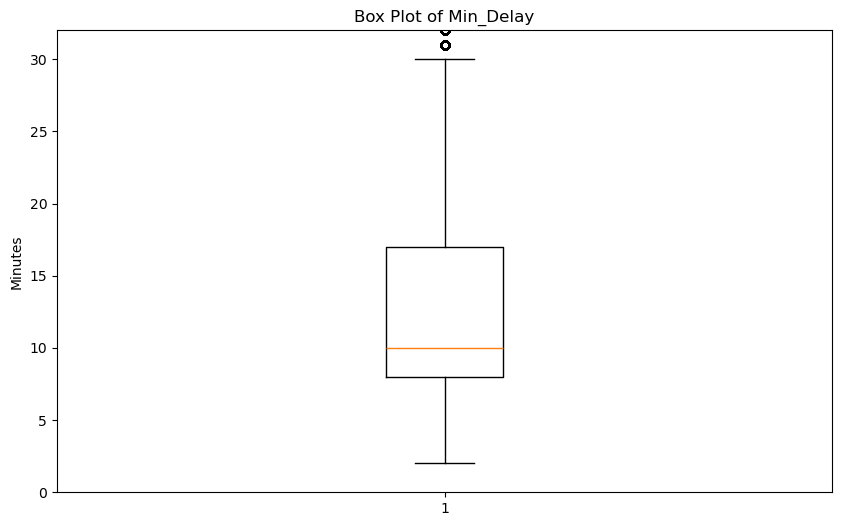

In [31]:
plot_min_delay_boxplot()


In [32]:
# Calculate quartile values
quartiles = ttc_df['Min_Delay'].quantile([0.25, 0.5, 0.75])

# Print quartile values
print("Quartile Values:")
print("25th Percentile (Q1):", quartiles[0.25])
print("Median (Q2):", quartiles[0.5])
print("75th Percentile (Q3):", quartiles[0.75])


Quartile Values:
25th Percentile (Q1): 8.0
Median (Q2): 10.0
75th Percentile (Q3): 17.0


In [33]:
def categorize_delay(delay, q1, q2, q3):
    if delay <= q1:
        return 'Short'
    elif delay <= q2:
        return 'Medium'
    else:
        return 'Long'

# Apply the categorize_delay function to create a new column 'Delay_Category'
ttc_df['Delay_Category'] = ttc_df['Min_Delay'].apply(lambda x: categorize_delay(x, 8.0, 10.0, 17.0))


Min Gap

In [34]:
# Remove rows with values of -2.0 and 0.0 in the 'Min_Gap' column from ttc_df
ttc_df = ttc_df[(ttc_df['Min_Gap'] != -2.0) & (ttc_df['Min_Gap'] != 0.0)]

# Remove Min Gap rows if there's no record of it.
ttc_df = ttc_df[ttc_df['Min_Gap'].notna()]


Direction

In [35]:
# standardizing and simplifying direction strings for easier processing and analysis.
def direction_simplifier(direction):
    direction = str(direction).upper().replace(' ', '')  # Convert to uppercase and remove spaces
    direction = re.sub(r'[^A-Z]', '', direction)  # Remove non-alphabetic characters

    if 'NB' in direction or 'N' in direction or 'NORTH' in direction:
        return 'N'
    elif 'SB' in direction or 'S' in direction or 'SOUTH' in direction:
        return 'S'
    elif 'EB' in direction or 'E' in direction or  'EAST' in direction:
        return 'E'
    elif 'WB' in direction or 'W' in direction or 'WEST' in direction:
        return 'W'
    elif 'BW' in direction or 'BWS' in direction or 'BOTH WAYS' in direction or 'BOTHWAY' in direction or 'BWAYS' in direction or 'B' in direction:
        return 'B'
    else:
        return 'Unknown'


In [36]:
ttc_df['Direction'] =ttc_df['Direction'].apply(direction_simplifier)


In [37]:
ttc_df['Direction'].value_counts()

Direction
N          178634
W          177053
S          123071
E          121432
Unknown      1454
B             155
Name: count, dtype: int64

Incidents

In [38]:
ttc_df.Incident.unique()

array(['Mechanical', 'General Delay', 'Emergency Services',
       'Investigation', 'Late Leaving Garage', 'Diversion',
       'Utilized Off Route', 'Late Leaving Garage - Mechanical',
       'Late Leaving Garage - Management', 'Late Leaving Garage - Vision',
       'Vision', 'Late Leaving Garage - Operator', nan, 'Management',
       'Operations - Operator', 'Cleaning', 'Security', 'Collision - TTC',
       'Road Blocked - NON-TTC Collision',
       'Road Block - Non-TTC Collision',
       'Roadblock by Collision - Non-TTC', 'Securitty',
       'Late Entering Service - Mechanical', 'Cleaning - Unsanitary',
       'Held By', 'Late Entering Service', 'Cleaning - Disinfection',
       'Late Leaving Garage - Operations', 'e', 'Operations',
       'Collision - TTC Involved', 'Late', 'Overhead', 'Rail/Switches'],
      dtype=object)

In [39]:
# Mapping dictionary for categorization
incident_mapping = {
    'Mechanical': 'Mechanical',
    'General Delay': 'Delay',
    'Emergency Services': 'Emergency Services',
    'Investigation': 'Investigation',
    'Diversion': 'Diversion',
    'Late Leaving Garage': 'Delay',
    'Utilized Off Route': 'Utilized Off Route',
    'Late Leaving Garage - Mechanical': 'Mechanical',
    'Late Leaving Garage - Management': 'Management',
    'Late Leaving Garage - Vision': 'Vision',
    'Vision': 'Vision',
    'Late Leaving Garage - Operator': 'Operator',
    'Management': 'Management',
    'Operations - Operator': 'Operations',
    'Cleaning': 'Cleaning',
    'Security': 'Security',
    'Collision - TTC': 'Collision',
    'Road Blocked - NON-TTC Collision': 'Collision',
    'Road Block - Non-TTC Collision': 'Collision',
    'Roadblock by Collision - Non-TTC': 'Collision',
    'Securitty': 'Security',
    'Late Entering Service - Mechanical': 'Mechanical',
    'Cleaning - Unsanitary': 'Cleaning',
    'Held By': 'Management',
    'Late Entering Service': 'Delay',
    'Cleaning - Disinfection': 'Cleaning',
    'Late Leaving Garage - Operations': 'Operations',
    'e': 'Unknown',
    'Operations': 'Operations',
    'Collision - TTC Involved': 'Collision',
    'Late': 'Delay',
    'Overhead': 'Overhead',
    'Rail/Switches': 'Operations'
}


# Update the incident column using the mapping
ttc_df['Incident'] = ttc_df['Incident'].map(incident_mapping)

# Fill NaN values with 'Unknown'
ttc_df['Incident'].fillna('Unknown', inplace=True)

In [40]:
ttc_df.Incident.value_counts()

Incident
Mechanical            222179
Delay                 128992
Utilized Off Route     70812
Investigation          48050
Operations             42078
Diversion              32320
Emergency Services     15400
Cleaning               14900
Collision              11423
Security                9335
Vision                  3220
Operator                1263
Management               938
Unknown                  873
Overhead                  16
Name: count, dtype: int64

Vehicle

In [41]:
# Dropping 'Vehicle' column as it does not provide any valuable insights and most of the data is NaN
ttc_df.drop(columns='Vehicle', axis=1, inplace=True)


In [42]:
def save_cleaned_data():
    ttc_df.to_csv("TTC_Cleaned.csv", index=False)

In [43]:
save_cleaned_data()


In [44]:
# Load your DataFrame (assume ttc_df_cleaned is ready)
ttc_df.to_sql('CleanedDelays', con=engine, if_exists='replace', index=False)



142

# EDA

In [45]:
def show_column_names():
    print(ttc_df.columns)


In [46]:
show_column_names()

Index(['Report_Date', 'Route', 'Time', 'Day_of_week', 'Location', 'Incident',
       'Min_Delay', 'Min_Gap', 'Direction', 'Report_Day', 'Report_Month',
       'Report_Year', 'Delay_Category'],
      dtype='object')


In [47]:
# Set the style for seaborn
sns.set_style("whitegrid")

In [48]:
# Plot Trend Analysis: Delays over time
def plot_delay_trend():
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Report_Date', y='Min_Delay', data=ttc_df, ci=None)
    plt.title('Trend of Delays Over Time')
    plt.xlabel('Report Date')
    plt.ylabel('Min Delay')
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set max number of x-axis ticks
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis ticks with commas
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

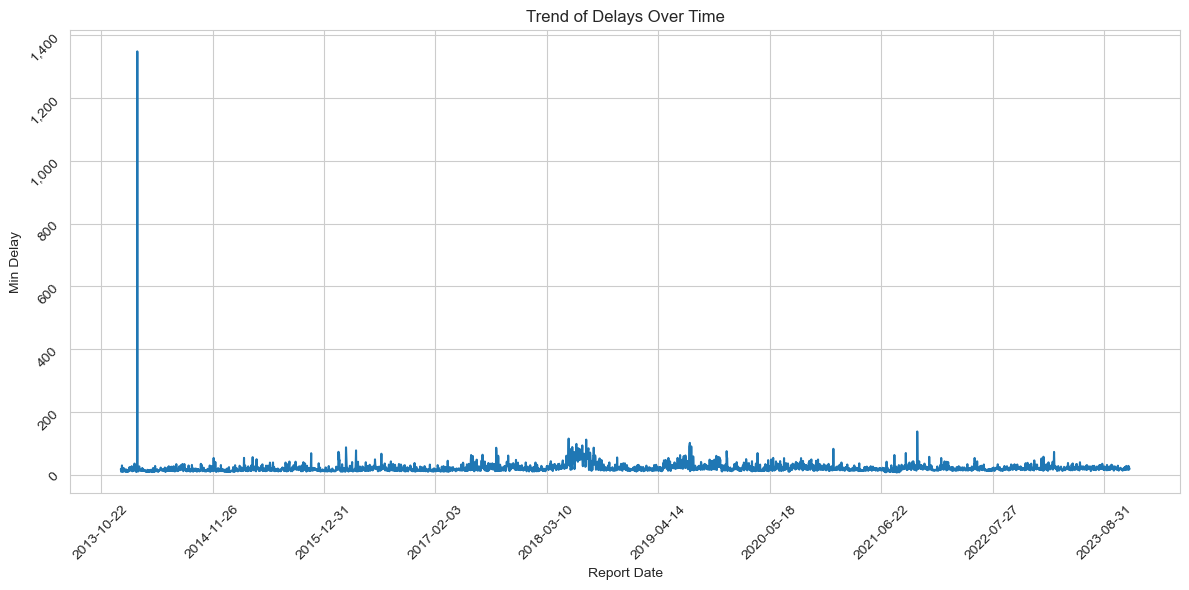

In [49]:
plot_delay_trend()


In [50]:
# Filter out delays greater than 200 minutes
def plot_delay_trend_no_outliers():
    filtered_ttc_df = ttc_df[ttc_df['Min_Delay'] <= 200]

# Plot Trend Analysis: Delays over time
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Report_Date', y='Min_Delay', data=filtered_ttc_df, ci=None)

    plt.title('Trend of Delays Over Time (Excluding Outliers)')
    plt.xlabel('Report Date')
    plt.ylabel('Min Delay')

    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  # Set max number of x-axis ticks
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:,.0f}'.format(x)))  # Format y-axis ticks with commas
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

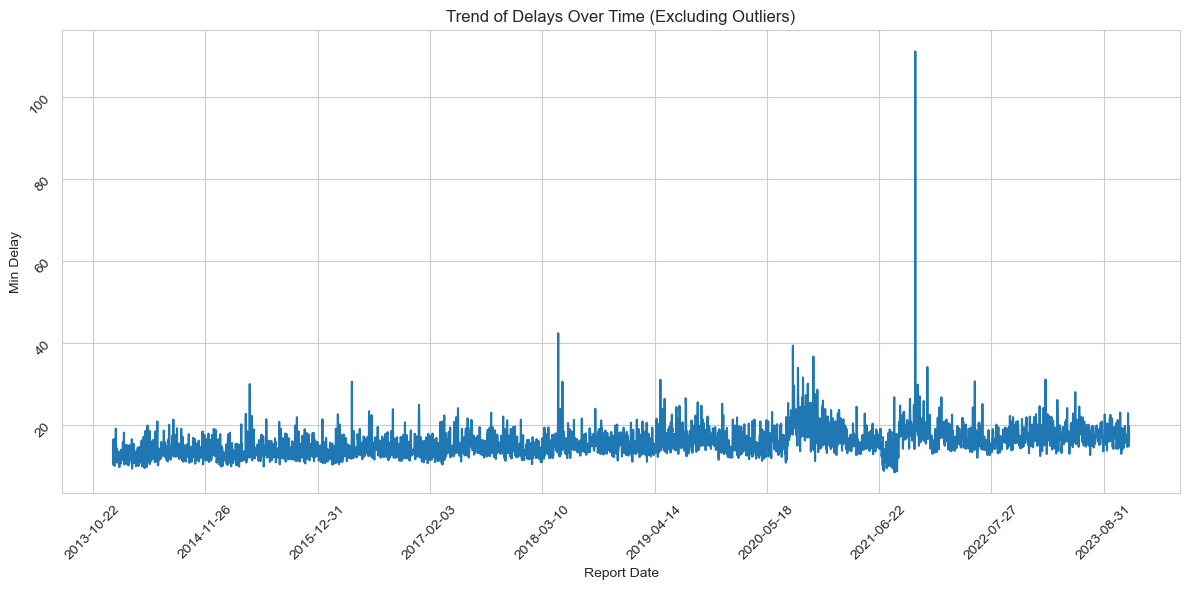

In [51]:
plot_delay_trend_no_outliers()

In [52]:
# Define the order of delay categories
def Order_delay_category():
    delay_category_order = ['Short', 'Medium', 'Long']

# Create the countplot with the specified order
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x='Delay_Category', data=ttc_df, order=delay_category_order)
    plt.title('Distribution of Delay Categories')
    plt.xlabel('Delay Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)

# Add numbers on top of each bar with commas for readability
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), '{:,.0f}'.format(p.get_height()), 
                fontsize=12, color='black', ha='center', va='bottom')

    plt.show()
    


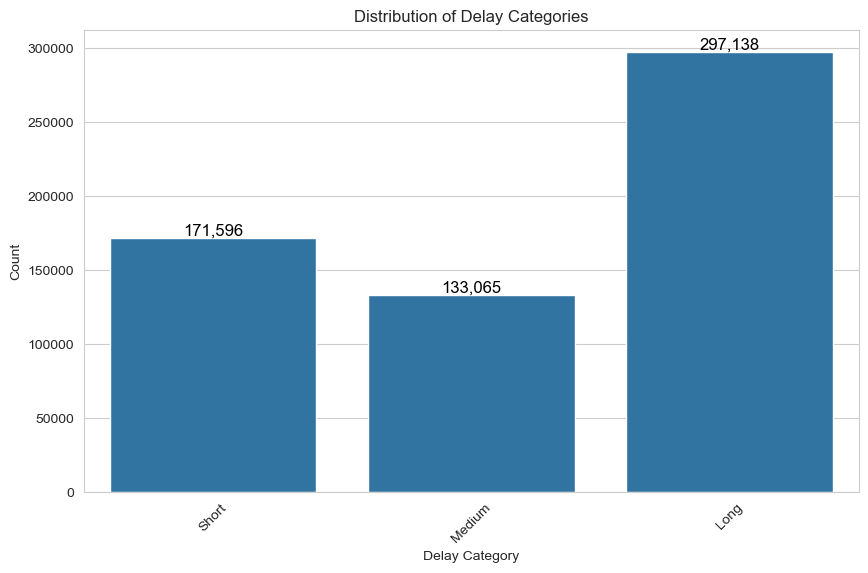

In [53]:
Order_delay_category()

## Which day of the week is the busiest? 

In [54]:
# Average Delay by Day of the Week
def avg_delay_of_week():
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Day_of_week', y='Min_Delay', data=ttc_df, ci=None, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

    plt.title("Average Delay by Day of the Week")
    plt.xlabel("Days of Week")
    plt.ylabel("Min Delay")

    plt.xticks(rotation=45)
    plt.yticks(rotation=45)

# Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.show()


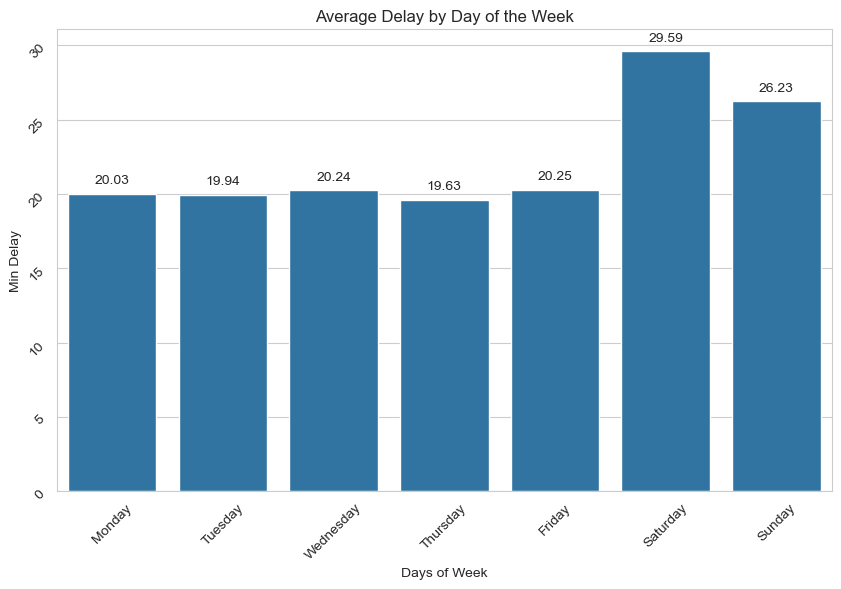

In [55]:
avg_delay_of_week()

# Which hours of the day are the busiest ?

In [56]:
def hours_of_day():
    ttc_df['Hour'] = pd.to_datetime(ttc_df['Time'], errors='coerce').dt.hour

    plt.figure(figsize=(10, 6))
    sns.histplot(ttc_df['Hour'].dropna(), bins=24, kde=False, color='skyblue')
    plt.title('Frequency of Delays by Hour of Day')
    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Delays')
    plt.xticks(range(0, 24))
    plt.tight_layout()
    plt.show()

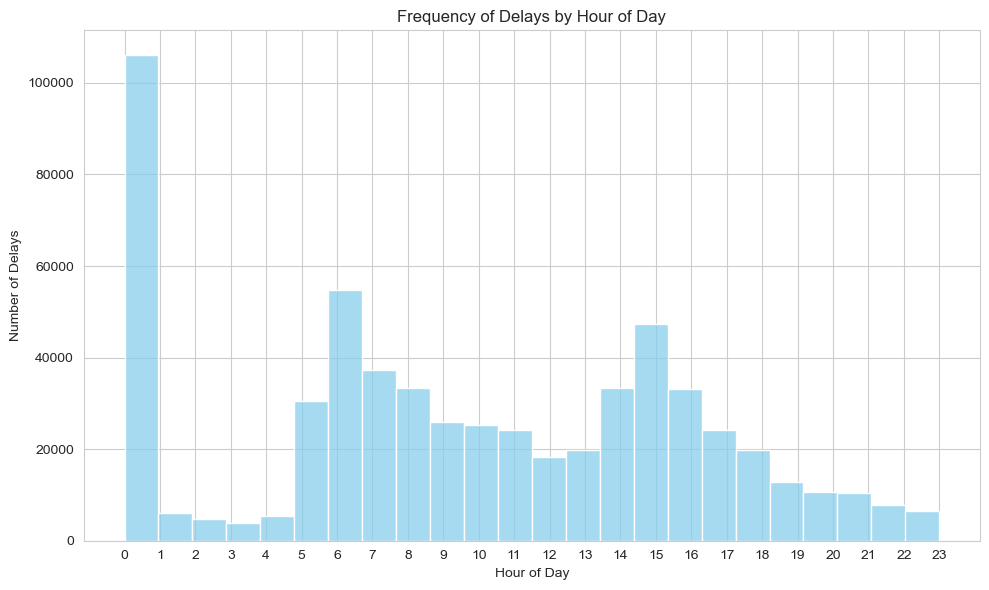

In [57]:
hours_of_day()

# Delay Heat map by Month and Year 


In [58]:
def heat_map():
    import calendar

# Pivot table
    pivot_table = ttc_df.pivot_table(index='Report_Month', columns='Report_Year', values='Min_Delay', aggfunc='mean')

# Create a list of month names
    month_names = [calendar.month_abbr[i] for i in range(1, 13)]

# Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt=".1f", cbar_kws={'label': 'Average Min Delay'})

# Set title and labels
    plt.title('Delay Heatmap by Month and Year')
    plt.xlabel('Year')
    plt.ylabel('Month')

    plt.xticks(rotation=45)
    plt.yticks(ticks=range(12), labels=month_names, rotation=0)  # Set custom y-tick labels

# Adjust layout
    plt.tight_layout()

    plt.show()


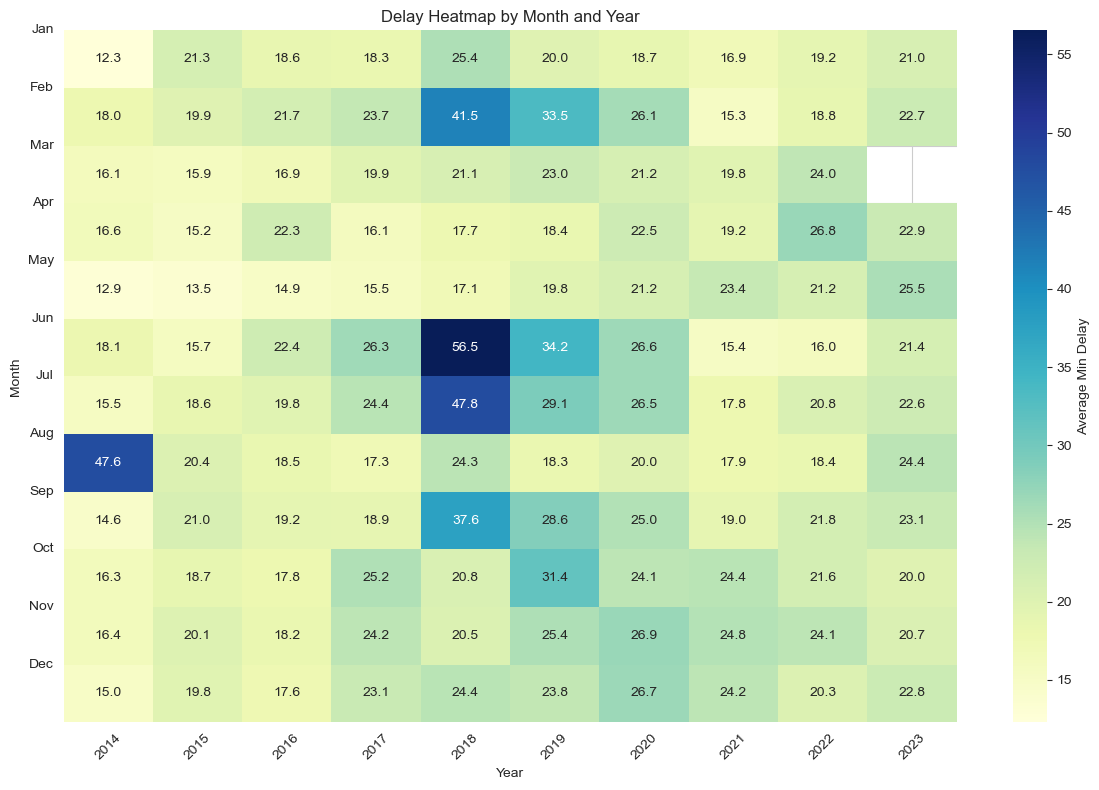

In [59]:
heat_map()

## Which is the most common incidents all?

In [60]:
# Most common types of incidents leading to delays
def most_common_incidents():
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Incident', data=ttc_df, order=ttc_df['Incident'].value_counts().index)
    plt.title('Distribution of Delay Incidents')
    plt.xlabel('Incident Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

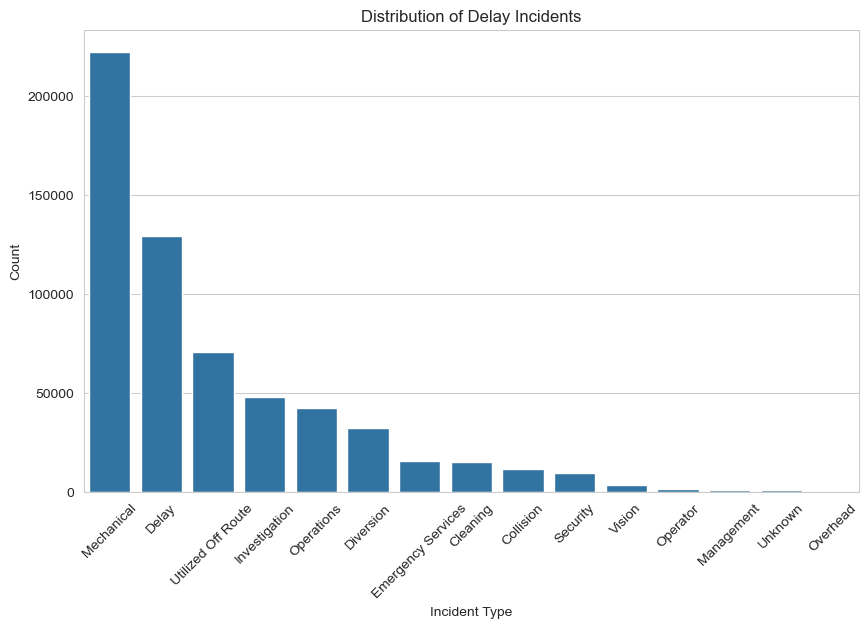

In [61]:
most_common_incidents()

# What is the delay distribution of top 10 routes?

In [62]:
def delay_distribution():
    top_routes = ttc_df['Route'].value_counts().head(10).index
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Route', y='Min_Delay', data=ttc_df[ttc_df['Route'].isin(top_routes)])
    plt.title('Delay Distribution by Top 10 Routes')
    plt.xlabel('Route')
    plt.ylabel('Min Delay')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


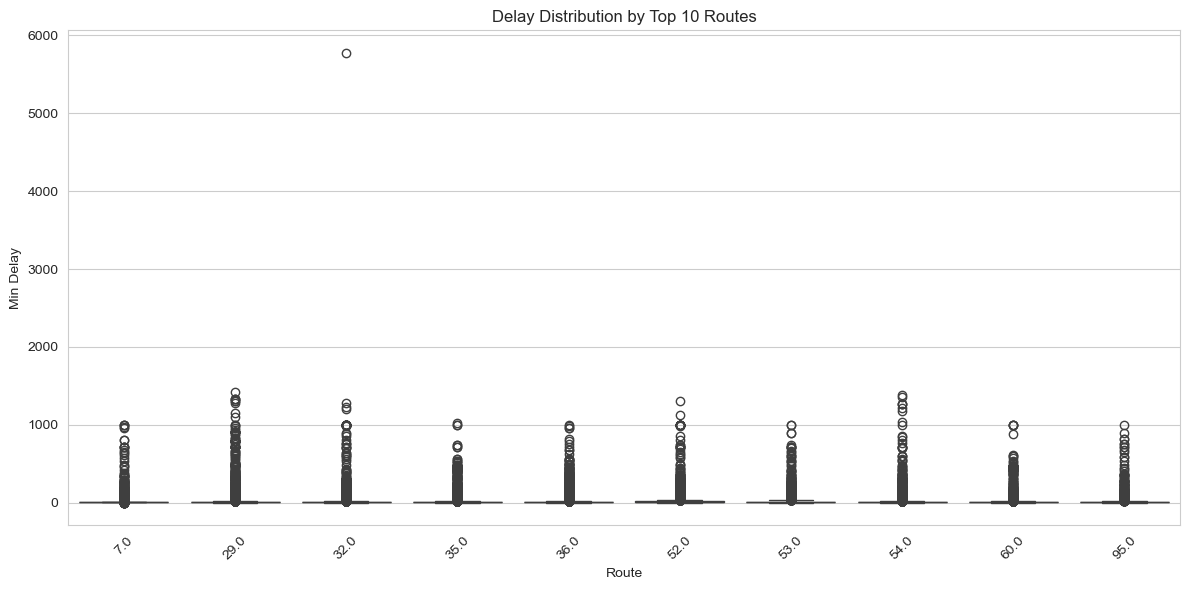

In [63]:
delay_distribution()

# What is the mean delay for top 10 routes?

In [64]:
# Calculate the mean delay for each route
def mean_delay():
    route_avg_delay = ttc_df.groupby('Route')['Min_Delay'].mean()

# Sort routes based on average delay in descending order
    top_routes_desc = route_avg_delay.sort_values(ascending=False).head(10).index

# Plot the routes with highest average delays
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Route', y='Min_Delay', data=ttc_df[ttc_df['Route'].isin(top_routes_desc)], ci=None, order=top_routes_desc)
    plt.title('Top 10 Routes with Highest Average Delays (Descending order)')
    plt.xlabel('Route')
    plt.ylabel('Average Min Delay')
    plt.xticks(rotation=45)
    plt.show()


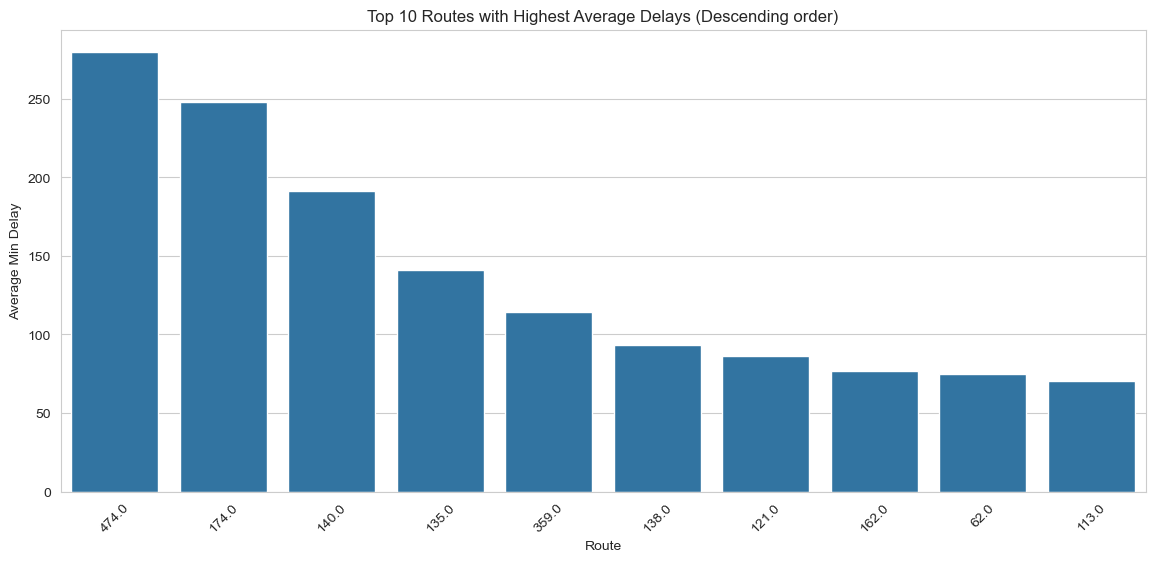

In [65]:
mean_delay()

## Top 10 locations with Most Frequent Delays

In [66]:
# Locations with most frequent delays
def frequent_delays():
    plt.figure(figsize=(10, 6))
    sns.countplot(x='Location', data=ttc_df, order=ttc_df['Location'].value_counts().index[:10])
    plt.title('Top 10 Locations with Most Frequent Delays')
    plt.xlabel('Location')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

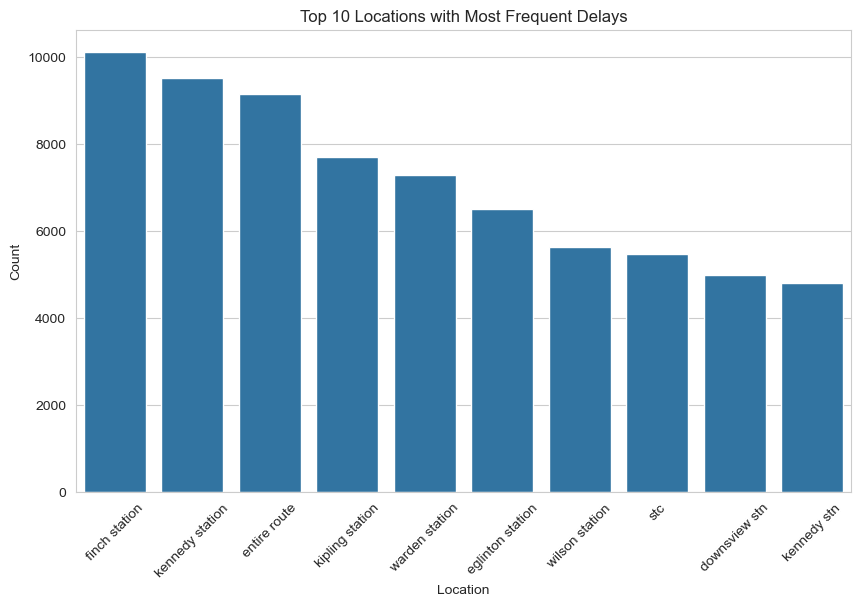

In [67]:
frequent_delays()

## Hypothesis testing 

In [68]:
# T-test Are weekend delays significantly different from weekday delays?
def ttest_weekend_vs_weekday():
    from scipy.stats import ttest_ind

# Example: test if delays are different between weekdays and weekends
    ttc_df['is_weekend'] = ttc_df['Day_of_week'].isin(['Saturday', 'Sunday'])

    weekend = ttc_df[ttc_df['is_weekend']]['Min_Delay']
    weekday = ttc_df[~ttc_df['is_weekend']]['Min_Delay']

    t_stat, p_val = ttest_ind(weekday, weekend)
    print("T-test result:", t_stat, p_val)

In [69]:
ttest_weekend_vs_weekday()

T-test result: -7.605603640722937 2.839851180412967e-14


In [70]:
# Chi-squaretest Is delay category dependent on day type?
def chisquare_delay_category():
    from scipy.stats import chi2_contingency

# Crosstab of Delay_Category and Day Type
    delay_day_ct = pd.crosstab(ttc_df['Delay_Category'], ttc_df['is_weekend'])

# Chi-square test
    chi2, p, dof, ex = chi2_contingency(delay_day_ct)
    print(f"Chi-square Test: Delay_Category vs Weekend\nChi2: {chi2:.2f}, P-value: {p:.4f}")

In [71]:
chisquare_delay_category()

Chi-square Test: Delay_Category vs Weekend
Chi2: 4949.49, P-value: 0.0000


In [72]:
#Anova Does average delay differ across different months?
def anova_avg_delay():
    from scipy.stats import f_oneway

# Group delay times by month
    groups = [group['Min_Delay'].values for name, group in ttc_df.groupby('Report_Month')]

# ANOVA
    f_stat, p_val = f_oneway(*groups)
    print(f"ANOVA: Min_Delay across Months\nF-statistic: {f_stat:.2f}, P-value: {p_val:.4f}")


In [73]:
anova_avg_delay()

ANOVA: Min_Delay across Months
F-statistic: 3.26, P-value: 0.0002


In [74]:
from scipy.stats import ttest_ind

In [75]:
# T-Test: Do mechanical issues result in longer delays than general delays?
def ttest_mechanical_issue():
    mechanical_delays = ttc_df[ttc_df['Incident'] == 'Mechanical']['Min_Delay']
    general_delays = ttc_df[ttc_df['Incident'] == 'Delay']['Min_Delay']

    t_stat, p_val = ttest_ind(mechanical_delays, general_delays, equal_var=False)
    print(f"T-test: Mechanical vs General Delays\nT-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

In [76]:
ttest_mechanical_issue()

T-test: Mechanical vs General Delays
T-statistic: -44.54, P-value: 0.0000


In [77]:
#T-test: Top 10 Routes vs Bottom 10 Routes Delay Duration
def top_vs_bottom_routes():
    top_routes = ttc_df['Route'].value_counts().head(10).index
    bottom_routes = ttc_df['Route'].value_counts().tail(10).index

    top_delays = ttc_df[ttc_df['Route'].isin(top_routes)]['Min_Delay']
    bottom_delays = ttc_df[ttc_df['Route'].isin(bottom_routes)]['Min_Delay']

    t_stat, p_val = ttest_ind(top_delays, bottom_delays, equal_var=False)
    print(f"T-test: Top 10 Routes vs Bottom 10 Routes\nT-statistic: {t_stat:.2f}, P-value: {p_val:.4f}")

In [78]:
top_vs_bottom_routes()

T-test: Top 10 Routes vs Bottom 10 Routes
T-statistic: 2.41, P-value: 0.0393


## Predictive Modeling 

In [79]:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

# Select features and target
features = ['Route', 'Min_Gap', 'Report_Year', 'Report_Day']  # Add encoded categorical vars
X = pd.get_dummies(ttc_df[features], drop_first=True)
y = ttc_df['Min_Delay']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [80]:
#Linear Regression( for delay minutes)
# Train model
def linear_regression():
    model = LinearRegression()
    model.fit(X_train, y_train)

# Evaluate
    y_pred_lr = model.predict(X_test)
    print("Linear Regression")
    print("R2 Score:", r2_score(y_test, y_pred_lr))
    print("MAE:", mean_absolute_error(y_test, y_pred_lr))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
    return y_test, y_pred_lr

In [81]:
y_test, y_pred_lr = linear_regression()


Linear Regression
R2 Score: 0.9290949294640772
MAE: 6.107293558990136
RMSE: 18.633961698226056


In [82]:
# Random Foret regressor 
def random_forest_regressor(X_train, y_train, X_test, y_test):
    from sklearn.ensemble import RandomForestRegressor

# Initialize and train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

# Predict and evaluate
    y_pred_rg = rf_model.predict(X_test)
    print("Random Forest Regressor")
    print("R2 Score:", r2_score(y_test, y_pred_rg))
    print("MAE:", mean_absolute_error(y_test, y_pred_rg))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rg)))
    return y_test, y_pred_rg, rf_model

In [83]:
y_test, y_pred_rg, rf_model = random_forest_regressor(X_train, y_train, X_test, y_test)


Random Forest Regressor
R2 Score: -10.439515200304411
MAE: 3.5977723933056187
RMSE: 236.68479639389645


In [84]:
# Gradient Boost Regressor
def gradient_boost_regressor(X_train, y_train, X_test, y_test):
    import xgboost as xgb

# Convert to DMatrix (optional, but recommended)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

# Parameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42
    }

# Train model
    xgb_model = xgb.train(params, dtrain, num_boost_round=100)

# Predict
    y_pred_xgb = xgb_model.predict(dtest)

# Evaluate
    print("XGBoost Regressor")
    print("R2 Score:", r2_score(y_test, y_pred_xgb))
    print("MAE:", mean_absolute_error(y_test, y_pred_xgb))
    print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
    return y_test, y_pred_xgb, xgb_model

In [85]:
y_test, y_pred_xgb, xgb_model = gradient_boost_regressor(X_train, y_train, X_test, y_test)

XGBoost Regressor
R2 Score: 0.8789598789090215
MAE: 3.2108540001817123
RMSE: 24.34620230776153


In [86]:
# Model Performance Comparison Bar Chart
def model_comparison():
# Dummy values — replace with your actual metrics
    model_metrics = {
        'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
        'R2 Score': [0.9290949294640772, -10.439515200304411 , 0.8789598789090215 ],
        'MAE': [6.107293558990136, 3.5977723933056187, 3.2108540001817123],
        'RMSE': [18.633961698226056, 236.68479639389645, 24.34620230776153]
    }

    df_metrics = pd.DataFrame(model_metrics)

# Plot R2 Score
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='R2 Score', data=df_metrics, palette='Blues_d')
    plt.title('R² Score Comparison')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    plt.show()

# Plot MAE
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='MAE', data=df_metrics, palette='Greens_d')
    plt.title('Mean Absolute Error (MAE) Comparison')
    plt.ylabel('MAE')
    plt.show()

# Plot RMSE
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Model', y='RMSE', data=df_metrics, palette='Reds_d')
    plt.title('Root Mean Squared Error (RMSE) Comparison')
    plt.ylabel('RMSE')
    plt.show()


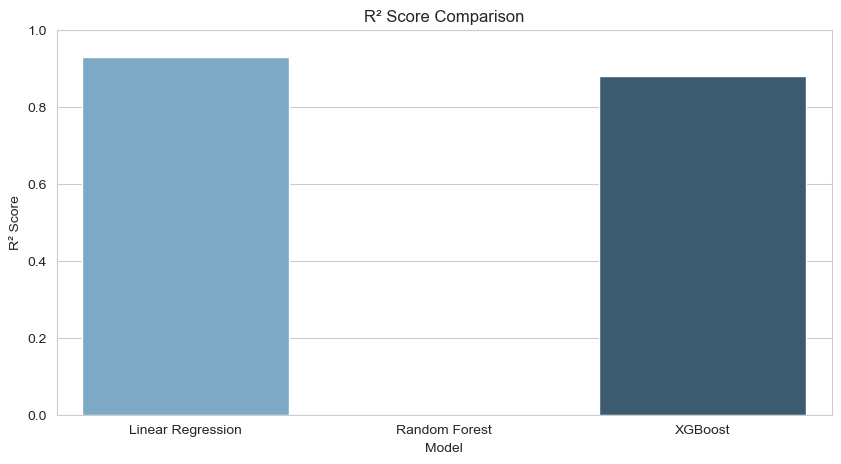

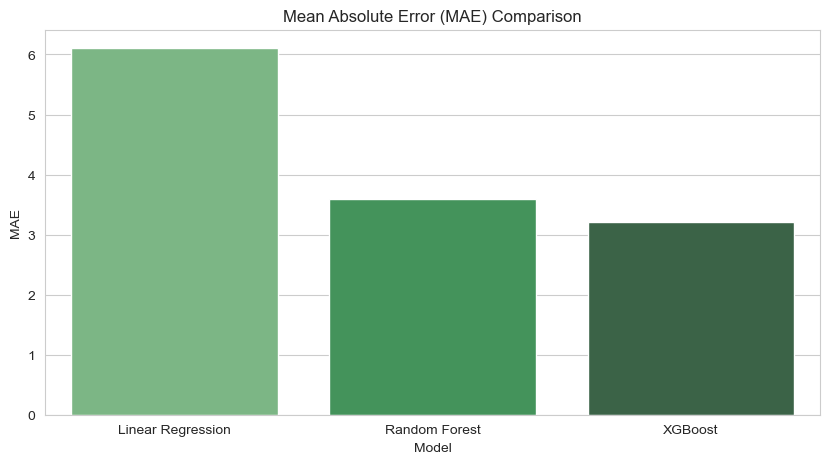

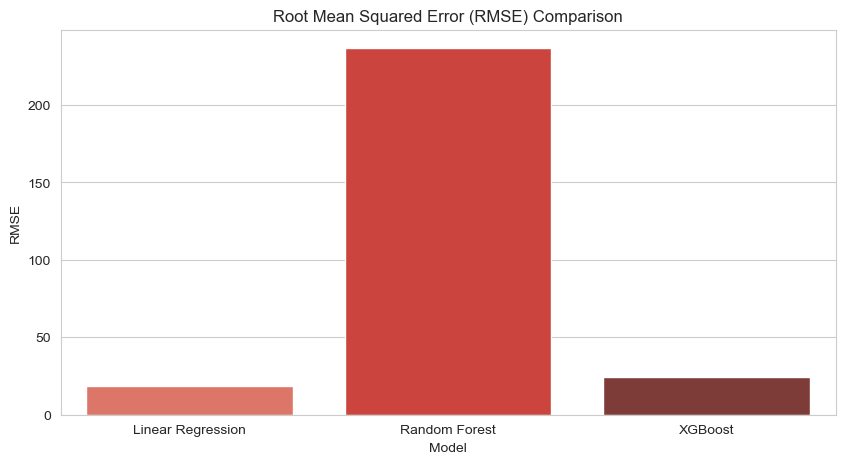

In [87]:
model_comparison()

In [88]:
# Actual Vs Predicted plot 
def actual_vs_predicted(y_test, y_pred_lr, y_pred_rg, y_pred_xgb):
# Set style
    sns.set(style="whitegrid")

# Plot all three in subplots
    plt.figure(figsize=(18, 5))

# Linear Regression
    plt.subplot(1, 3, 1)
    sns.scatterplot(x=y_test, y=y_pred_lr, alpha=0.6, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title('Linear Regression: Actual vs Predicted')

# Random Forest
    plt.subplot(1, 3, 2)
    sns.scatterplot(x=y_test, y=y_pred_rg, alpha=0.6, color='green')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title('Random Forest: Actual vs Predicted')

# XGBoost
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6, color='orange')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
    plt.xlabel('Actual Delay')
    plt.ylabel('Predicted Delay')
    plt.title('XGBoost: Actual vs Predicted')

    plt.tight_layout()
    plt.show()


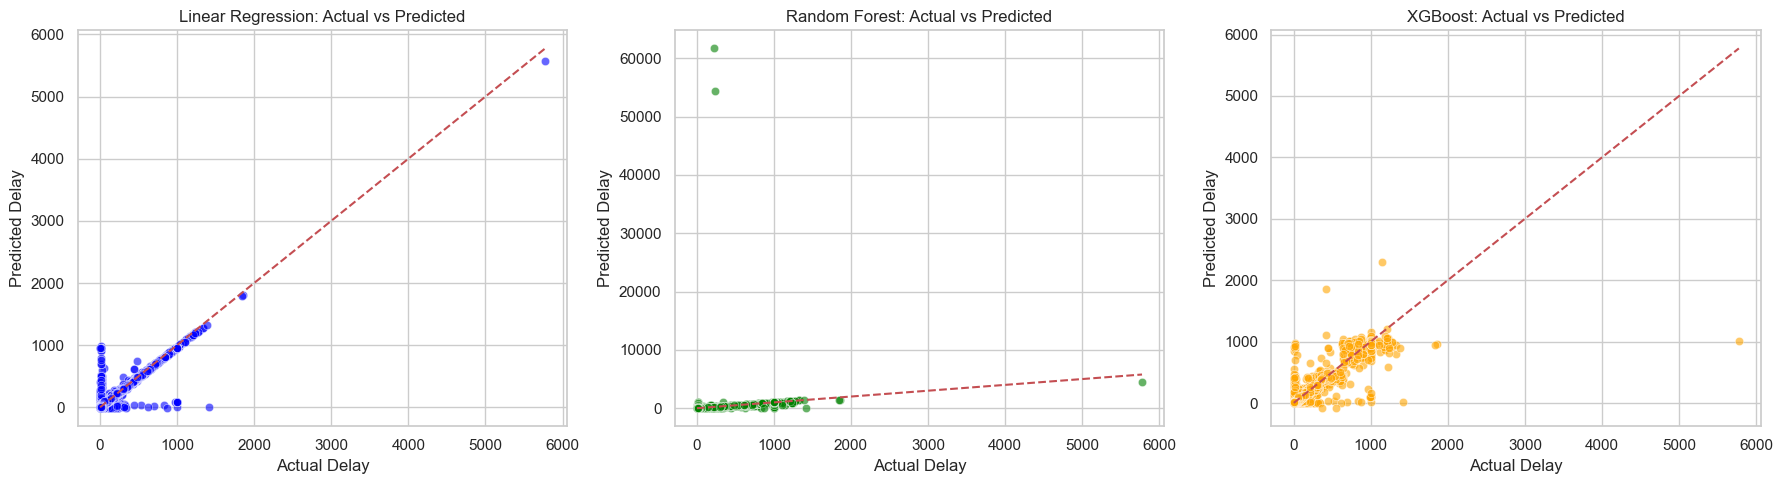

In [89]:
actual_vs_predicted(y_test, y_pred_lr, y_pred_rg, y_pred_xgb)


In [90]:
# Random forest feature importance 
def plot_rf_feature_importance(rf_model, X):
    importances = rf_model.feature_importances_
    features = X.columns

# Create a DataFrame and sort
    feat_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

# Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feat_df, palette='viridis')
    plt.title('Top Feature Importances (Random Forest)')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


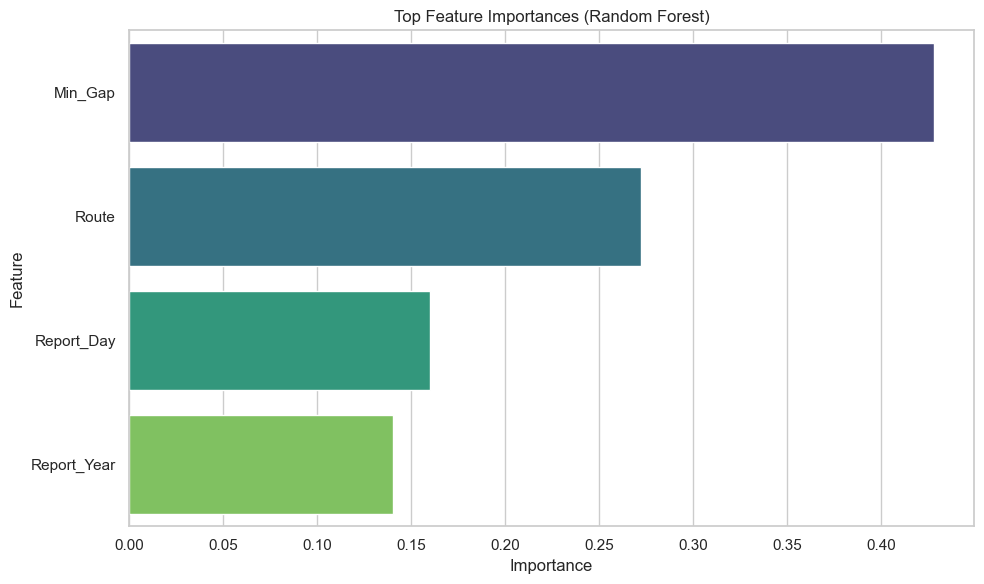

In [91]:
plot_rf_feature_importance(rf_model, X)


In [92]:
def plot_xgb_feature_importance(xgb_model, max_features=15):
    import matplotlib.pyplot as plt
    import xgboost as xgb

    xgb.plot_importance(xgb_model, max_num_features=max_features, height=0.5)
    plt.title('XGBoost Feature Importance')
    plt.show()


plot_xgb_feature_importance(xgb_model)
